### 1. Výpočet tepové frekvence z EKG signálu

In [1]:
import wfdb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# https://physionet.org/content/butqdb/1.0.0/
ecg_100001 = wfdb.rdrecord("100001_ECG")

In [3]:
signal_info = [
    ["Název souboru", ecg_100001.record_name],
    ["Vzorkovací frekvence", ecg_100001.fs],
    ["Délka signálu (vzorky)", ecg_100001.sig_len],
    ["Počet kanálů", ecg_100001.n_sig],
    ["Názvy kanálů", ", ".join(ecg_100001.sig_name)],
    ["Jednotky pro každý kanál", ", ".join(ecg_100001.units)],
]

pd.DataFrame(signal_info, columns=["Informace", "Hodnota"])

,Informace,Hodnota
0,Název souboru,100001_ECG
1,Vzorkovací frekvence,1000
2,Délka signálu (vzorky),87087000
3,Počet kanálů,1
4,Názvy kanálů,ECG
5,Jednotky pro každý kanál,uV


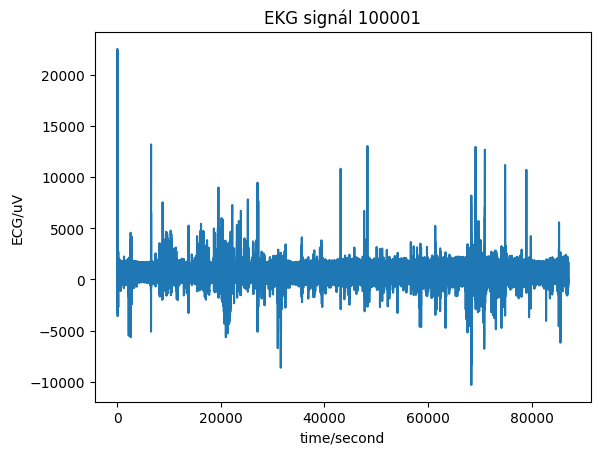

In [4]:
wfdb.plot_wfdb(record=ecg_100001, title="EKG signál 100001")

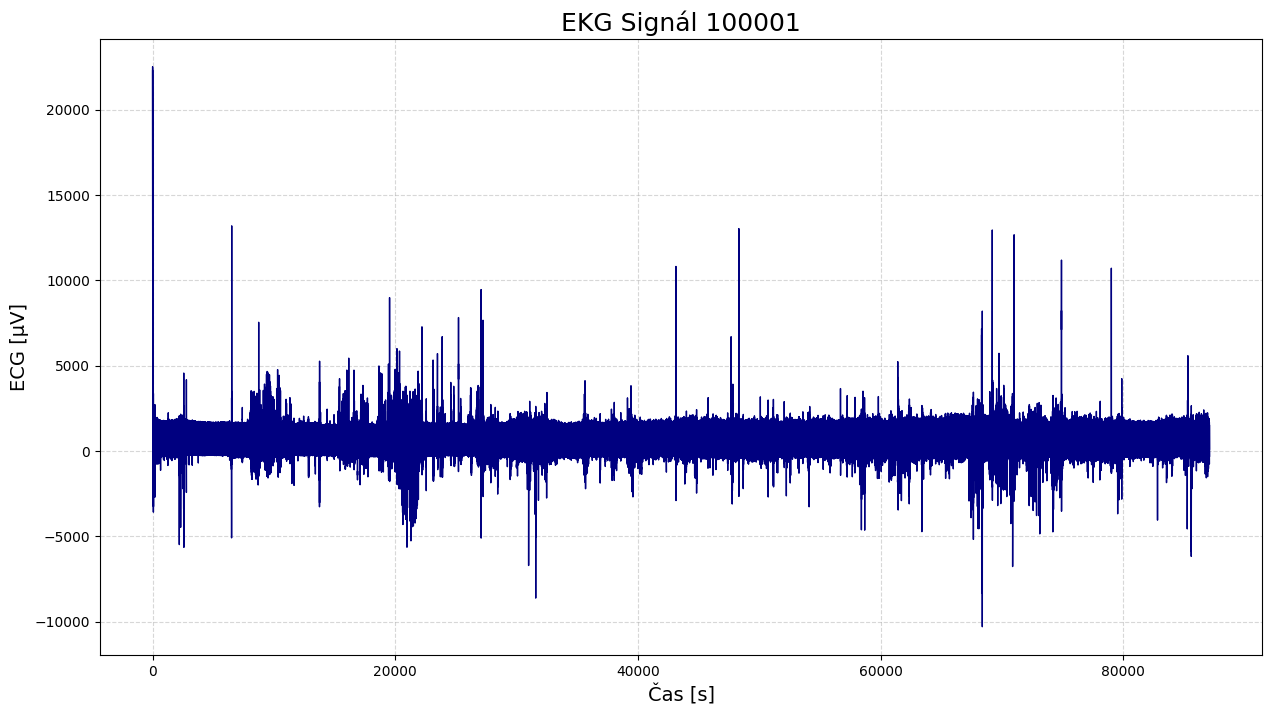

In [25]:
ecg_signal = ecg_100001.p_signal
sampling_frequency = 1000
time_axis = np.arange(len(ecg_signal)) / sampling_frequency

plt.figure(figsize=(15, 8))
plt.plot(time_axis, ecg_signal, color="navy", linewidth=1)
plt.title("EKG Signál 100001", fontsize=18)
plt.xlabel("Čas [s]", fontsize=14)
plt.ylabel("ECG [µV]", fontsize=14)
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()

- Tabulka obsahuje 3 sloupce:
  1. **Měření ECG_1001**
  2. **Tepová frekvence**
  3. **Procentuální míra detekce R peaků**
- Porovnání detekce R peaků mezi mými výsledky a výsledky od kolegy. Výsledky budou srovnány s anotacemi od experta.

- Každé měření je reprezentováno jako jeden vektor.
- Po načtení signálu je třeba provést následující kroky:
  - **Detrendování** signálu (odstranění trendů).
  - Ověření, že signál je **spojitý**.
  - **Centralizace** signálu, aby měl střed okolo nuly.
- Tyto kroky jsou součástí **preprocessingu EKG signálu**.

- **R Peak** (vrchol R): každý R peak odpovídá jednomu tepu srdce.
- Je nutné navrhnout spolehlivou metodu pro detekci R peaků, která:
  - Bude schopna identifikovat R peaky i v případech, kdy jsou méně výrazné nebo chybí.


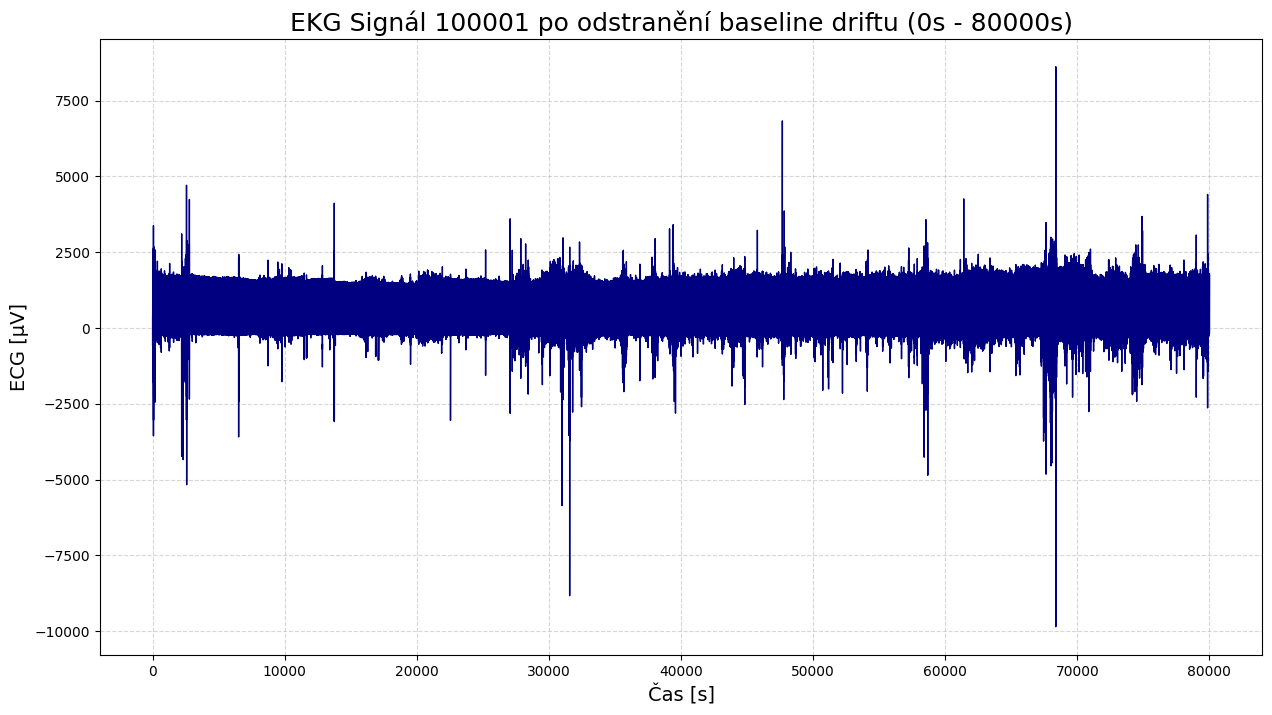

In [61]:
time_axis = np.arange(len(ecg_signal)) / sampling_frequency

start_time = 0
end_time = 80000

start_index = int(start_time * sampling_frequency)
end_index = int(end_time * sampling_frequency)

ecg_signal_slice = ecg_signal[start_index:end_index]
time_axis_slice = time_axis[start_index:end_index]

# plt.figure(figsize=(15, 8))
# plt.plot(time_axis_slice, ecg_signal_slice, color="navy", linewidth=1)
# plt.title(f"EKG Signál 100001 ({start_time}s - {end_time}s)", fontsize=18)
# plt.xlabel("Čas [s]", fontsize=14)
# plt.ylabel("ECG [µV]", fontsize=14)
# plt.grid(True, linestyle="--", alpha=0.5)
# plt.show()

from scipy.signal import butter, filtfilt

# Parametry filtru
cutoff_frequency = 0.5  # V Hz, odstraní frekvence pod touto hodnotou
order = 4  # Pořadí filtru

# Návrh vysokofrekvenčního Butterworthova filtru
b, a = butter(order, cutoff_frequency / (sampling_frequency / 2), btype="high")
ecg_signal_detrended = filtfilt(b, a, ecg_signal_slice)

# Vizualizace detrendovaného signálu
plt.figure(figsize=(15, 8))
plt.plot(time_axis_slice, ecg_signal_detrended, color="navy", linewidth=1)
plt.title(
    f"EKG Signál 100001 po odstranění baseline driftu ({start_time}s - {end_time}s)",
    fontsize=18,
)
plt.xlabel("Čas [s]", fontsize=14)
plt.ylabel("ECG [µV]", fontsize=14)
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()

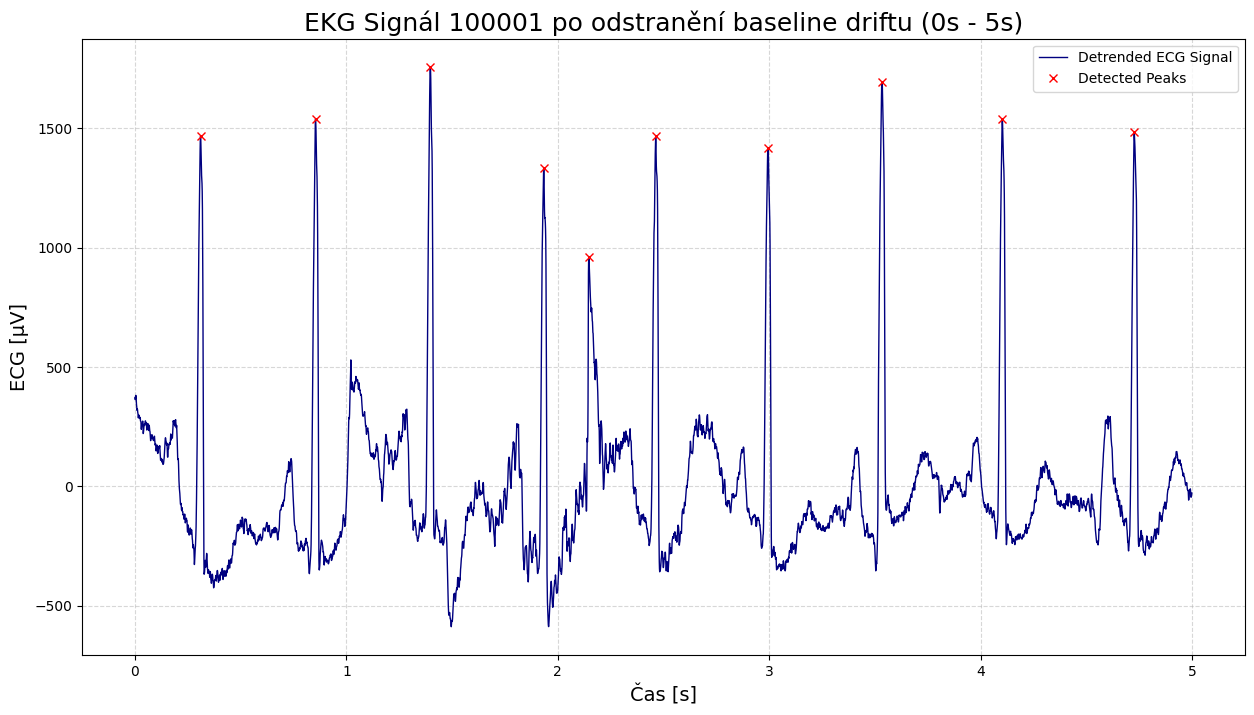

In [60]:
from scipy.signal import butter, filtfilt, find_peaks
import matplotlib.pyplot as plt

# Parametry filtru
cutoff_frequency = 0.5  # V Hz, odstraní frekvence pod touto hodnotou
order = 4  # Pořadí filtru

# Návrh vysokofrekvenčního Butterworthova filtru
b, a = butter(order, cutoff_frequency / (sampling_frequency / 2), btype="high")
ecg_signal_detrended = filtfilt(b, a, ecg_signal_slice)

# Detekce vrcholů EKG signálu
peaks, _ = find_peaks(
    ecg_signal_detrended, prominence=1000
)  # distance je parametr pro minimální vzdálenost mezi vrcholy

# Vizualizace detrendovaného signálu
plt.figure(figsize=(15, 8))
plt.plot(
    time_axis_slice,
    ecg_signal_detrended,
    color="navy",
    linewidth=1,
    label="Detrended ECG Signal",
)
plt.plot(
    time_axis_slice[peaks], ecg_signal_detrended[peaks], "rx", label="Detected Peaks"
)  # Zobrazíme vrcholy jako červené kříže
plt.title(
    f"EKG Signál 100001 po odstranění baseline driftu ({start_time}s - {end_time}s)",
    fontsize=18,
)
plt.xlabel("Čas [s]", fontsize=14)
plt.ylabel("ECG [µV]", fontsize=14)
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend()
plt.show()

In [68]:
# Band-Pass Filtr (Pásmová propusť) - propustit ty signály, které nedávají smysl?
# 0.5 mV až 5 mV (500 µV až 5000 µV) - smysluplný fyziologický signál